
# Fig 3: petri dish

Proportion of each age group experiencing different # of attributable heat stress days 

Credit for Figure code Luethi et al: xx 

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, statsmodels

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.image as mpimg
from matplotlib.patches import Circle
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import LogNorm
%matplotlib inline 
plt.rcdefaults()

import numpy as np
import pandas as pd

# import fxns 
from functions import *
from utils import *
from plotscript import *

# import other packages/modules 
sys.path.append(os.path.join(os.environ['VSC_DATA_VO_USER'],'demographics4climate/'))
from population_demographics import * 

In [2]:
dirname='output_empirical'
models='ISIMIP3b'
figdir = os.path.join(figdirs, 'fig_feb25')

#dir_shift_fit = 'forster2024-hitol-nan'


In [3]:
def reporting_summary(df, args, axis=1):
    #summary = {arg: getattr(df, arg)(axis=axis) for arg in args}
    summary = {}
        # Iterate over each requested summary statistic
    for arg in args:
        if arg == "q1":
            summary["Q1"] = df.quantile(0.25, axis=axis)
        elif arg == "q3":
            summary["Q3"] = df.quantile(0.75, axis=axis)
        else:
            # Handle standard functions like "min", "max", "median"
            summary[arg] = getattr(df, arg)(axis=axis)
    
    # Concatenate results along columns
    df_summary = pd.concat(summary, axis=1)
    
    return df_summary.astype('float64').round(2)

## Petri dish: Functions

In [4]:
'''------------------------------------------------------------------------'''
''' Plot petridish '''

class Point:
    """A little class representing an SVG circle."""

    def __init__(self, cx, cy, r, icolour=None):
        """Initialize the circle with its centre, (cx,cy) and radius, r.

        icolour is the index of the circle's colour.

        """
        self.cx, self.cy, self.r = cx, cy, r
        self.icolour = icolour

    def overlap_with(self, cx, cy, r):
        """Does the circle overlap with another of radius r at (cx, cy)?"""

        d = np.hypot(cx-self.cx, cy-self.cy)
        return d < r + self.r

class PointCloud:
    """A class for drawing circles-inside-a-circle.
    Inspired by https://scipython.com/blog/packing-circles-in-a-circle/
    """

    def __init__(self, width=600, height=600, R=250, n=800, rho_min=0.005,
                 rho_max=0.05, colours=None):
        """Initialize the Circles object.

        width, height are the SVG canvas dimensions
        R is the radius of the large circle within which the small circles are
        to fit.
        n is the maximum number of circles to pack inside the large circle.
        rho_min is rmin/R, giving the minimum packing circle radius.
        rho_max is rmax/R, giving the maximum packing circle radius.
        colours is a list of SVG fill colour specifiers to be referenced by
            the class identifiers c<i>. If None, a default palette is set.

        """

        self.width, self.height = width, height
        self.R, self.n = R, n
        # The centre of the canvas
        self.CX, self.CY = self.width // 2, self.height // 2
        self.rmin, self.rmax = R * rho_min, R * rho_max
        self.colours = colours or ['#993300', '#a5c916', '#00AA66', '#FF9900']

   
    def _place_circle(self, r):
        # The guard number: if we don't place a circle within this number
        # of trials, we give up.
        guard = 500
        while guard:
            # Pick a random position, uniformly on the larger circle's interior
            cr, cphi = ( self.R * np.sqrt(np.random.random()),
                         2*np.pi * np.random.random() )
            cx, cy = cr * np.cos(cphi), cr * np.sin(cphi)
            if cr+r < self.R:
            # The circle fits inside the larger circle.
                if not any(circle.overlap_with(self.CX+cx, self.CY+cy, r)
                                    for circle in self.circles):
                    # The circle doesn't overlap any other circle: place it.
                    circle = Point(cx+self.CX, cy+self.CY, r,
                                icolour=np.random.randint(len(self.colours)))
                    self.circles.append(circle)
                    return
            guard -= 1
        # Warn that we reached the guard number of attempts and gave up for
        # for this circle.
        print('guard reached.')

    def make_circles(self):
        """Place the little circles inside the big one."""

        # First choose a set of n random radii and sort them. We use
        # random.random() * random.random() to favour small circles.
        self.circles = []
        r = self.rmin + (self.rmax - self.rmin) * np.random.random(
                                self.n) * np.random.random(self.n)
        r[::-1].sort()
        # Do our best to place the circles, larger ones first.
        for i in range(self.n):
            self._place_circle(r[i])



In [5]:
def prep_data_petri_dish(da, ages=[80,60,40,20,0],cmap='inferno_r',gray=True): # MY VERSION
    cm = plt.get_cmap(cmap)
    cols = [cm(i / 10) for i in range(10)]
    
    # make colors for petri dishes
    c = np.arange(0,100,1); col_lvls = dict(); al_lvls = dict()
    
    ages = [80,60,40,20,0]
    
    for i, age in enumerate(ages):
        props = np.empty(len(da_prop_people_ndays_models.features))
        for j in range(len(da_prop_people_ndays_models.features)):
            prop = da.sel(age_ranges=age).to_pandas().median(axis=0)[j]
            props[j] = prop

        print(age, [round(props[i],2) for i in range(len(da_prop_people_ndays_models.features))] )
        
        al = []; col = []
        for j in c:
            if j < np.round(props[-1]*100): col.append(cols[9]); al.append(1) 
            elif j < np.round(props[-2]*100): col.append(cols[6]); al.append(0.8)
            elif j < np.round(props[-3]*100): col.append(cols[3]); al.append(0.6)
            elif j < np.round(props[-4]*100): col.append(cols[1]); al.append(0.4)
            else: col.append('gray'); al.append(0.15)
    
        col_lvls[i] = col
        al_lvls[i] = al

    return col_lvls, al_lvls


In [6]:
def plot_petri_dish_2lvls(col_lvls, al_lvls, col_lvls_15=None, al_lvls_15=None, 
                          col_lvls_2=None, al_lvls_2=None, nrows=1, title='', 
                          labels=['Global warming \nto 2023', '1.5$\degree$C', '2$\degree$C'], 
                          sort_points=False,
                         legtitle='Attributable days per year'):

    R = 65
    
    def plot_circle_row(ax, col_lvls, al_lvls, wl_name, sort_points, row_offset=0):
        """Helper function to plot a row of circles."""
        for w, wlevel in enumerate(wl_name):
            cloud = PointCloud(width=100, height=100, R=R, n=100, rho_min=0.065, rho_max=0.065)
            cloud.make_circles()

            while len(cloud.circles) < 100:
                cloud = PointCloud(width=100, height=100, R=R, n=100, rho_min=0.065, rho_max=0.065)
                cloud.make_circles()

            cx = np.array([c.cx for c in cloud.circles])
            cy = np.array([c.cy for c in cloud.circles])

            if sort_points:
                r = (cx - 50.) ** 2 + (cy - 50) ** 2
                r_ind = 99 - np.argsort(r.argsort())
                col = [col_lvls[w][i] for i in r_ind]
                al = [al_lvls[w][i] for i in r_ind]
            else:
                col = col_lvls[w]
                al = al_lvls[w]

            ax[w + row_offset].scatter(cx, cy, s=200, marker='o', c=col, alpha=al)
            ax[w + row_offset].add_patch(Circle((50, 50), R, facecolor='none', edgecolor='black', linewidth=1, alpha=1))
            ax[w + row_offset].axis('off')
            ax[w + row_offset].set_aspect('equal')
            if row_offset == 0:
                ax[w + row_offset].set_title(wlevel, fontsize=24)
    
    ages = [80, 60, 40, 20, 0]
    wl_name = [f'{age}-{age + 9}' for age in ages]  # Age levels


    
    fig, axes = plt.subplots(nrows, 5, figsize=(18, 4 * nrows))
    plt.suptitle(title, fontsize=20, fontweight='bold')
    
    axes = axes.flatten()
    plot_circle_row(axes, col_lvls, al_lvls, wl_name, sort_points)

    if nrows > 1:
        plot_circle_row(axes, col_lvls_15, al_lvls_15, wl_name, sort_points, row_offset=len(wl_name))

    if nrows > 2:
        plot_circle_row(axes, col_lvls_2, al_lvls_2, wl_name, sort_points, row_offset=2 * len(wl_name))

    plt.subplots_adjust(bottom=0.2, 
                        top=0.9,
                        wspace=0.1, 
                        hspace=0.1)

    # Create legend
    cm = plt.get_cmap('inferno_r')
    cols = [cm(i / 10) for i in range(10)]
    p0 = plt.plot(np.NaN, np.NaN, color='gray', markersize=15, marker='o', linestyle='', alpha=.3)
    p1 = plt.plot(np.NaN, np.NaN, color=cols[1], markersize=15, marker='o', linestyle='')
    p2 = plt.plot(np.NaN, np.NaN, color=cols[3], markersize=15, marker='o', linestyle='')
    p3 = plt.plot(np.NaN, np.NaN, color=cols[6], markersize=15, marker='o', linestyle='')
    p4 = plt.plot(np.NaN, np.NaN, color=cols[9], markersize=15, marker='o', linestyle='')

    leg = plt.legend([p0[0], p1[0], p2[0], p3[0], p4[0]],
                     [f'$\leq${x_hot_days[1]}', f'{x_hot_days[1]}-{x_hot_days[2]}',
                      f'{x_hot_days[2]}-{x_hot_days[3]}', f'{x_hot_days[3]}-{x_hot_days[4]}',
                      f'$\geq${x_hot_days[4]}'],
                     loc='lower center', ncol=5, bbox_to_anchor=(-1.8, -0.25),
                     fontsize=18, frameon=False) #title=legtitle)

    plt.annotate(legtitle, (.5, .075),xycoords='figure fraction', fontsize=18, ha='center')
    
    y_positions = [0.7, 0.47, 0.23]  


    if nrows >= 2:
        plt.annotate(labels[0], (.07, y_positions[0]), xycoords='figure fraction', fontsize=18, ha='center', fontweight='bold')
        plt.annotate(labels[1], (.07, y_positions[1]), xycoords='figure fraction', fontsize=18, ha='center', fontweight='bold')
    if nrows == 3:
        plt.annotate(labels[2], (.07, y_positions[2]), xycoords='figure fraction', fontsize=18, ha='center', fontweight='bold')



## Prep data: demographics



In [7]:
gs_population_global_2023 = population_demographics_gridscale_global(startyear=2023,
                                                                endyear=2023,
                                                                ssp=2,
                                                                urbanrural=False)

loading country masks
interpolating cohort sizes per country
calculating gridscale demographics


In [8]:
gs_population_global_2023.sum().values

array(8.00851946e+09)

In [9]:
gs_population_global_2034 = population_demographics_gridscale_global(startyear=2034,
                                                                endyear=2034,
                                                                ssp=2,
                                                                urbanrural=False)

loading country masks
interpolating cohort sizes per country
calculating gridscale demographics


In [10]:
gs_population_global_2062 = population_demographics_gridscale_global(startyear=2062,
                                                                endyear=2062,
                                                                ssp=2,
                                                                urbanrural=False)

loading country masks
interpolating cohort sizes per country
calculating gridscale demographics


In [11]:
gs_population_global_2050 = population_demographics_gridscale_global(startyear=2050,
                                                                endyear=2050,
                                                                ssp=2,
                                                                urbanrural=False)

loading country masks
interpolating cohort sizes per country
calculating gridscale demographics


In [12]:
gs_population_global_2033_ssp3 = population_demographics_gridscale_global(startyear=2033,
                                                                endyear=2033,
                                                                ssp=3,
                                                                urbanrural=False)

loading country masks
interpolating cohort sizes per country
calculating gridscale demographics


In [13]:
gs_population_global_2062_ssp3 = population_demographics_gridscale_global(startyear=2062,
                                                                endyear=2062,
                                                                ssp=3,
                                                                urbanrural=False)

loading country masks
interpolating cohort sizes per country
calculating gridscale demographics


In [14]:
gs_population_global_2056 = population_demographics_gridscale_global(startyear=2056,
                                                                endyear=2056,
                                                                ssp=2,
                                                                urbanrural=False)

loading country masks
interpolating cohort sizes per country
calculating gridscale demographics


In [15]:
gs_population_global_2051_ssp3 = population_demographics_gridscale_global(startyear=2051,
                                                                endyear=2051,
                                                                ssp=3,
                                                                urbanrural=False)

loading country masks
interpolating cohort sizes per country
calculating gridscale demographics


## Prep data: climate + demographics

In [16]:
x_hot_days = [0, 1, 50, 100, 150]

year=2023

In [17]:


da_nAHD_models = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 

da_nAHD = da_nAHD_models

da_n_people_ndays_models, da_prop_people_ndays_models = calc_number_proportion_people_atleastxdays_10yr(gs_population_global_2023, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = x_hot_days)



da_nAHD_percapita_peopledays = calc_percapita_hotdays_peopledays_1yr(gs_population_global_2023, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

In [18]:

temp_target=1.5

da_nAHD_models = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, temp_target=temp_target) # see here i coded what models it is in the fxn 

da_nAHD = da_nAHD_models

da_n_people_ndays_models_15, da_prop_people_ndays_models_15 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global_2034, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = x_hot_days)

da_nAHD_percapita_peopledays_15 = calc_percapita_hotdays_peopledays_1yr(gs_population_global_2034, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

In [19]:

temp_target=2

da_nAHD_models = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, temp_target=temp_target) # see here i coded what models it is in the fxn 

da_nAHD = da_nAHD_models

da_n_people_ndays_models_2, da_prop_people_ndays_models_2 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global_2062, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = x_hot_days)



da_nAHD_percapita_peopledays_2 = calc_percapita_hotdays_peopledays_1yr(gs_population_global_2062, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

In [20]:
da_prop_people_ndays_models.sel(age_ranges=0).to_pandas().median(axis=0)


features
prop_atleast_0      0.998481
prop_atleast_1      0.740551
prop_atleast_50     0.287109
prop_atleast_100    0.106679
prop_atleast_150    0.030711
dtype: object

In [21]:
col_lvls, al_lvls = prep_data_petri_dish(da_prop_people_ndays_models)


80 [1.0, 0.63, 0.12, 0.04, 0.02]
60 [1.0, 0.7, 0.18, 0.06, 0.03]
40 [1.0, 0.73, 0.22, 0.08, 0.03]
20 [1.0, 0.75, 0.27, 0.1, 0.03]
0 [1.0, 0.74, 0.29, 0.11, 0.03]


In [22]:
col_lvls_15, al_lvls_15 = prep_data_petri_dish(da_prop_people_ndays_models_15)


80 [1.0, 0.68, 0.16, 0.06, 0.02]
60 [1.0, 0.75, 0.23, 0.09, 0.04]
40 [1.0, 0.76, 0.27, 0.11, 0.04]
20 [1.0, 0.76, 0.32, 0.13, 0.04]
0 [1.0, 0.75, 0.34, 0.13, 0.04]


In [23]:
col_lvls_2, al_lvls_2 = prep_data_petri_dish(da_prop_people_ndays_models_2)


80 [1.0, 0.77, 0.29, 0.12, 0.07]
60 [1.0, 0.8, 0.39, 0.17, 0.09]
40 [1.0, 0.79, 0.42, 0.2, 0.1]
20 [1.0, 0.79, 0.44, 0.23, 0.1]
0 [1.0, 0.78, 0.45, 0.23, 0.1]


# Plot

guard reached.


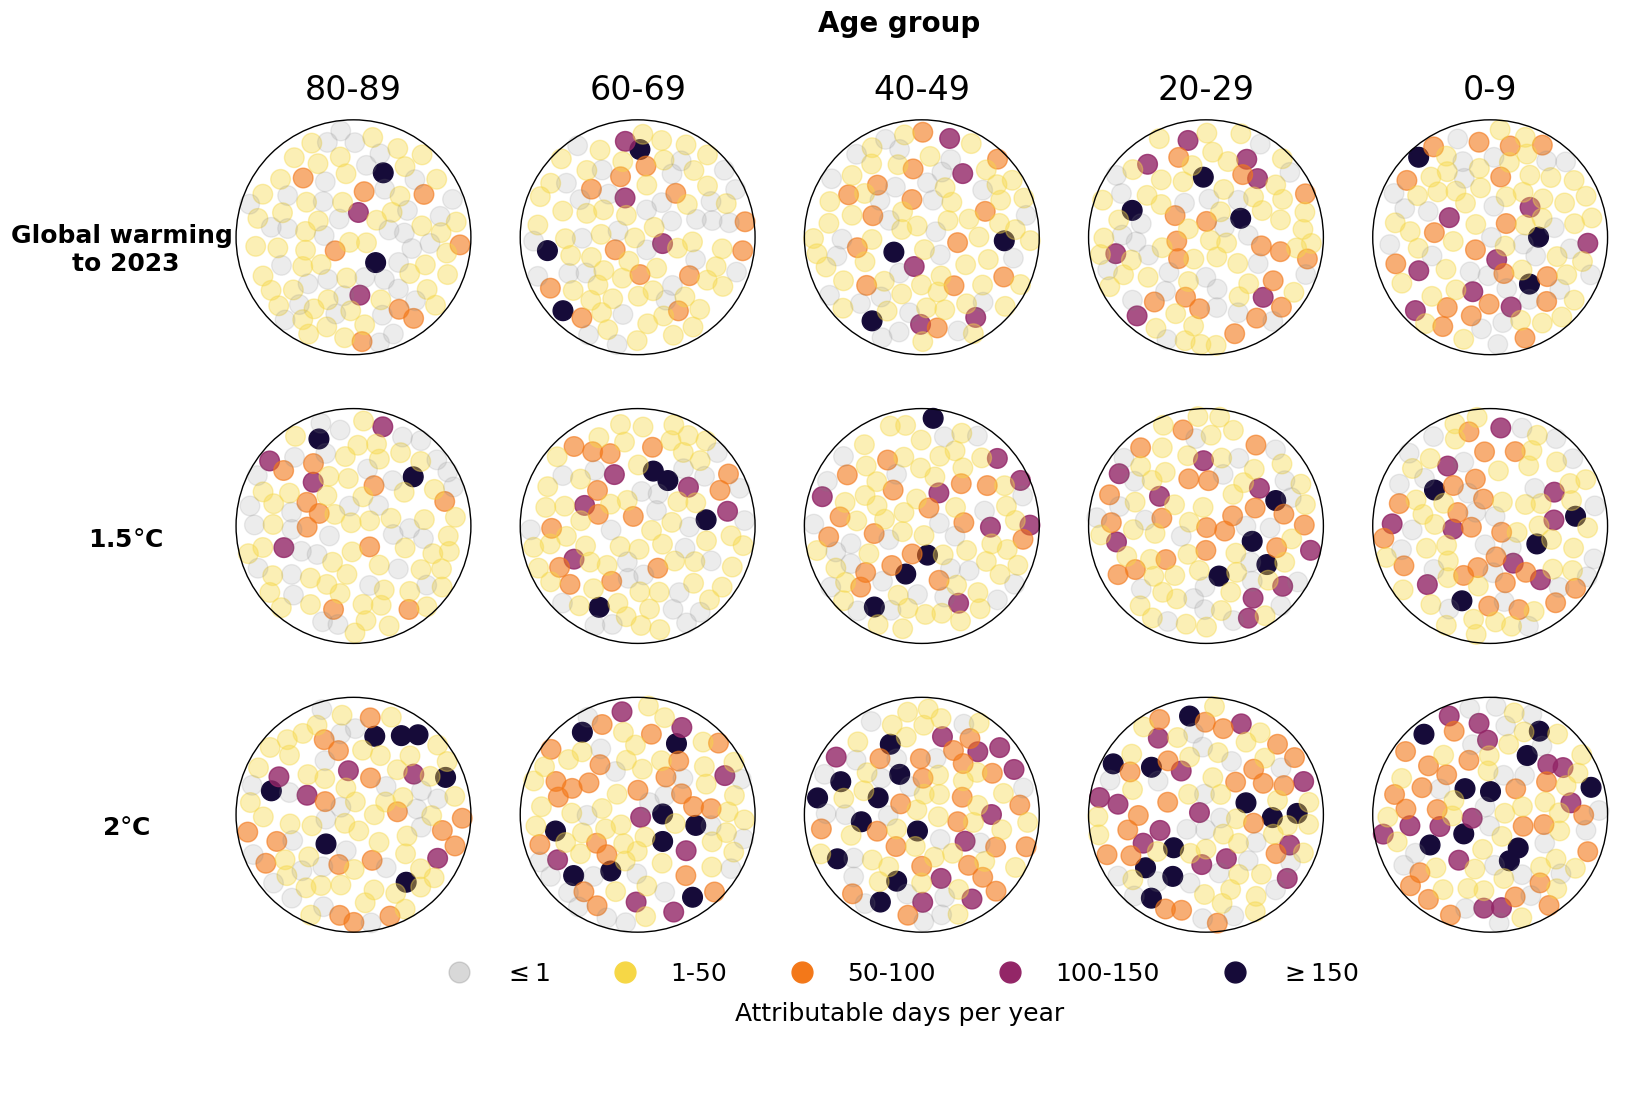

In [24]:
plot_petri_dish_2lvls(col_lvls,al_lvls, col_lvls_15,al_lvls_15, col_lvls_2,al_lvls_2,
                          nrows=3,
                     title='Age group')

# Save the figure
# plt.savefig(os.path.join(figdir, 'fig3_v2.png'), dpi=300, bbox_inches='tight', transparent=True)
# plt.savefig(os.path.join(figdir, 'fig3_v2.pdf'), dpi=300, bbox_inches='tight', transparent=True)


# Reporting numbers



## numbers behind figure

In [25]:
# proportion of peole living through different frequency changes 

da_prop_people_ndays_models.astype(float).median(dim='model').to_pandas().round(2)

features,prop_atleast_0,prop_atleast_1,prop_atleast_50,prop_atleast_100,prop_atleast_150
age_ranges,,,,,
0,1.0,0.74,0.29,0.11,0.03
10,1.0,0.75,0.28,0.10,0.03
20,1.0,0.75,0.27,0.10,0.03
30,1.0,0.74,0.23,0.09,0.03
40,1.0,0.73,0.22,0.08,0.03
50,1.0,0.73,0.20,0.07,0.03
60,1.0,0.70,0.18,0.06,0.03
70,1.0,0.67,0.15,0.05,0.02
80,1.0,0.63,0.12,0.04,0.02


In [26]:
da_prop_people_ndays_models_15.astype(float).median(dim='model').to_pandas().round(2)

features,prop_atleast_0,prop_atleast_1,prop_atleast_50,prop_atleast_100,prop_atleast_150
age_ranges,,,,,
0,1.0,0.75,0.34,0.13,0.04
10,1.0,0.75,0.33,0.13,0.04
20,1.0,0.76,0.32,0.13,0.04
30,1.0,0.76,0.30,0.12,0.04
40,1.0,0.76,0.27,0.11,0.04
50,1.0,0.75,0.26,0.10,0.04
60,1.0,0.75,0.23,0.09,0.04
70,1.0,0.72,0.20,0.08,0.03
80,1.0,0.68,0.16,0.06,0.02


In [27]:
da_prop_people_ndays_models_2.astype(float).median(dim='model').to_pandas().round(2)

features,prop_atleast_0,prop_atleast_1,prop_atleast_50,prop_atleast_100,prop_atleast_150
age_ranges,,,,,
0,1.0,0.78,0.45,0.23,0.10
10,1.0,0.78,0.44,0.23,0.10
20,1.0,0.79,0.44,0.23,0.10
30,1.0,0.79,0.43,0.22,0.10
40,1.0,0.79,0.42,0.20,0.10
50,1.0,0.80,0.41,0.19,0.10
60,1.0,0.80,0.39,0.17,0.09
70,1.0,0.79,0.34,0.14,0.08
80,1.0,0.77,0.29,0.12,0.07


In [28]:
# proportion of people living through less than 1 AHD 

print((1 - da_prop_people_ndays_models.astype(float).median(dim='model').to_pandas()['prop_atleast_1']).round(2),
(1 - da_prop_people_ndays_models_15.astype(float).median(dim='model').to_pandas()['prop_atleast_1']).round(2),
(1 - da_prop_people_ndays_models_2.astype(float).median(dim='model').to_pandas()['prop_atleast_1']).round(2))

age_ranges
0     0.26
10    0.25
20    0.25
30    0.26
40    0.27
50    0.27
60    0.30
70    0.33
80    0.37
90    0.40
Name: prop_atleast_1, dtype: float64 age_ranges
0     0.25
10    0.25
20    0.24
30    0.24
40    0.24
50    0.25
60    0.25
70    0.28
80    0.32
90    0.35
Name: prop_atleast_1, dtype: float64 age_ranges
0     0.22
10    0.22
20    0.21
30    0.21
40    0.21
50    0.20
60    0.20
70    0.21
80    0.23
90    0.26
Name: prop_atleast_1, dtype: float64


## n people 0-9 v. 60-69

In [29]:
# number of people present day (behind figure)

(da_n_people_ndays_models.astype(float).median(dim='model').to_pandas() /1e6).round(0) # unit: millions

features,n_atleast_0,n_atleast_1,n_atleast_50,n_atleast_100,n_atleast_150
age_ranges,,,,,
0,1313.0,974.0,377.0,140.0,40.0
10,1281.0,958.0,356.0,134.0,41.0
20,1188.0,891.0,316.0,117.0,38.0
30,1177.0,871.0,273.0,101.0,36.0
40,1005.0,736.0,223.0,83.0,32.0
50,873.0,636.0,171.0,63.0,26.0
60,637.0,448.0,113.0,41.0,17.0
70,360.0,243.0,53.0,19.0,7.0
80,135.0,85.0,17.0,5.0,2.0


In [30]:
# ratio number of people 0-9 / n people 60-69

da = da_n_people_ndays_models.isel(features=slice(1,None))
d1 = (da.sel( age_ranges=0) / da.sel( age_ranges=60)).astype(float).median(dim='model').to_pandas()

da = da_n_people_ndays_models_15.isel(features=slice(1,None))
d2 = (da.sel( age_ranges=0) / da.sel( age_ranges=60)).astype(float).median(dim='model').to_pandas()

da = da_n_people_ndays_models_2.isel(features=slice(1,None))
d3 = (da.sel( age_ranges=0) / da.sel( age_ranges=60)).astype(float).median(dim='model').to_pandas()

df_npeople_ratio_0_60 = pd.concat([d1, d2, d3], axis=1, keys=["pd", "1.5", "2"])

df_npeople_ratio_0_60.round(1)

,pd,1.5,2
features,,,
n_atleast_1,2.2,1.6,1.1
n_atleast_50,3.3,2.4,1.3
n_atleast_100,3.1,2.3,1.4
n_atleast_150,2.3,1.7,1.2


In [31]:
df_npeople_ratio_0_60.agg(["min", "max"]).T.round(1)

# range across different definitions

,min,max
pd,2.2,3.3
1.5,1.6,2.4
2,1.1,1.4


In [32]:
# difference number of people 0-9 - n people 60-69

da = da_n_people_ndays_models.isel(features=slice(1,None))
d1 = (da.sel( age_ranges=0) - da.sel( age_ranges=60)).astype(float).median(dim='model').to_pandas()

da = da_n_people_ndays_models_15.isel(features=slice(1,None))
d2 = (da.sel( age_ranges=0) - da.sel( age_ranges=60)).astype(float).median(dim='model').to_pandas()

da = da_n_people_ndays_models_2.isel(features=slice(1,None))
d3 = (da.sel( age_ranges=0) - da.sel( age_ranges=60)).astype(float).median(dim='model').to_pandas()

df_npeople_diff_0_60 = pd.concat([d1, d2, d3], axis=1, keys=["pd", "1.5", "2"])

(df_npeople_diff_0_60 / 1e6).round(0)

,pd,1.5,2
features,,,
n_atleast_1,526.0,354.0,61.0
n_atleast_50,266.0,251.0,111.0
n_atleast_100,96.0,98.0,74.0
n_atleast_150,24.0,20.0,20.0


## proportion 0-9 v 60-69

In [33]:
# ratio prop of people 0-9 / n people 60-69

da = da_prop_people_ndays_models.isel(features=slice(1,None))
d1 = (da.sel( age_ranges=0) / da.sel( age_ranges=60)).astype(float).median(dim='model').to_pandas()

da = da_prop_people_ndays_models_15.isel(features=slice(1,None))
d2 = (da.sel( age_ranges=0) / da.sel( age_ranges=60)).astype(float).median(dim='model').to_pandas()

da = da_prop_people_ndays_models_2.isel(features=slice(1,None))
d3 = (da.sel( age_ranges=0) / da.sel( age_ranges=60)).astype(float).median(dim='model').to_pandas()

df_prop_ratio_0_60 = pd.concat([d1, d2, d3], axis=1, keys=["pd", "1.5", "2"])

df_prop_ratio_0_60.round(1) # ratio

,pd,1.5,2
features,,,
prop_atleast_1,1.1,1.0,1.0
prop_atleast_50,1.6,1.5,1.2
prop_atleast_100,1.5,1.5,1.3
prop_atleast_150,1.1,1.1,1.1


In [34]:
# difference prop of people 0-9 - prop people 60-69

da = da_prop_people_ndays_models.isel(features=slice(1,None))
d1 = (da.sel( age_ranges=0) - da.sel( age_ranges=60)).astype(float).median(dim='model').to_pandas()

da = da_prop_people_ndays_models_15.isel(features=slice(1,None))
d2 = (da.sel( age_ranges=0) -da.sel( age_ranges=60)).astype(float).median(dim='model').to_pandas()

da = da_prop_people_ndays_models_2.isel(features=slice(1,None))
d3 = (da.sel( age_ranges=0) - da.sel( age_ranges=60)).astype(float).median(dim='model').to_pandas()

df_prop_ratio_0_60 = pd.concat([d1, d2, d3], axis=1, keys=["pd", "1.5", "2"])

(df_prop_ratio_0_60 * 100).round(0) # percent difference

,pd,1.5,2
features,,,
prop_atleast_1,4.0,1.0,-2.0
prop_atleast_50,11.0,12.0,7.0
prop_atleast_100,4.0,4.0,5.0
prop_atleast_150,0.0,0.0,1.0


# Sensitivity to demographics

## 0. Plot demographic changes in SSP1, SSP2 and SSP3

In [35]:
df_cohort_sizes_ssp2, ages, years = load_cohort_sizes(ssp=2)
da_cohort_sizes = interpolate_cohortsize_countries(df_cohort_sizes_ssp2,
                                                 ages,
                                                 years).sel(country='World')

da_cohort_sizes

interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 10, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 102, Libyan Arab Jamahiriya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 136, Papua New Guinea, setting them to zero


<xarray.DataArray 'cohort_size' (time: 151, ages: 105)>
array([[7.31588080e+04, 7.04181240e+04, 6.76774400e+04, ...,
        6.31111539e+00, 8.33346176e-01, 0.00000000e+00],
       [7.61880568e+04, 7.32772464e+04, 7.03664360e+04, ...,
        5.80193459e+00, 6.66676941e-01, 0.00000000e+00],
       [7.92173056e+04, 7.61363688e+04, 7.30554320e+04, ...,
        5.29275379e+00, 5.00007706e-01, 0.00000000e+00],
       ...,
       [8.32193000e+04, 8.39108080e+04, 8.46023160e+04, ...,
        9.16576800e+03, 6.74742880e+03, 4.32908960e+03],
       [8.25226360e+04, 8.32086120e+04, 8.38945880e+04, ...,
        9.40474400e+03, 6.93128240e+03, 4.45782080e+03],
       [8.18259720e+04, 8.25064160e+04, 8.31868600e+04, ...,
        9.64372000e+03, 7.11513600e+03, 4.58655200e+03]])
Coordinates:
    country  <U5 'World'
  * time     (time) int64 1950 1951 1952 1953 1954 ... 2096 2097 2098 2099 2100
  * ages     (ages) int64 0 1 2 3 4 5 6 7 8 ... 96 97 98 99 100 101 102 103 104

In [36]:
df_cohort_sizes_ssp3, ages, years = load_cohort_sizes(ssp=3)
da_cohort_sizes_ssp3 = interpolate_cohortsize_countries(df_cohort_sizes_ssp3,
                                                 ages,
                                                 years).sel(country='World')

interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 10, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 102, Libyan Arab Jamahiriya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 136, Papua New Guinea, setting them to zero


In [37]:
df_cohort_sizes_ssp1, ages, years = load_cohort_sizes(ssp=1)
da_cohort_sizes_ssp1 = interpolate_cohortsize_countries(df_cohort_sizes_ssp1,
                                                 ages,
                                                 years).sel(country='World')

interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 10, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 102, Libyan Arab Jamahiriya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 136, Papua New Guinea, setting them to zero


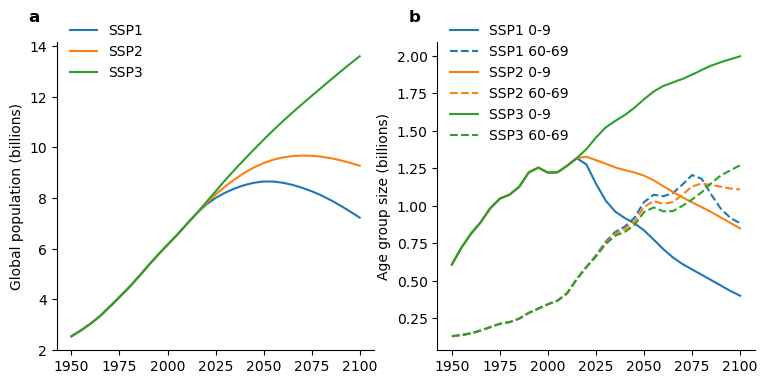

In [38]:
# settings
xpos=-.09
ypos=1.04


fig, axes = plt.subplots(1,2, figsize=(9,4))

ax=axes[0]
ax.set_title('a',loc='left',fontweight='bold',x=xpos,y=ypos)

(da_cohort_sizes_ssp1/1e6).sum(dim='ages').plot(ax=ax, label = 'SSP1')
(da_cohort_sizes/1e6).sum(dim='ages').plot(ax=ax, label = 'SSP2')
(da_cohort_sizes_ssp3/1e6).sum(dim='ages').plot(ax=ax, label = 'SSP3')


ax.legend(frameon=False,bbox_to_anchor=(0, 1.1),loc='upper left')
ax.set_title('')
ax.set_ylabel('Global population (billions)')
ax.set_xlabel('')


ax=axes[1]
ax.set_title('b',loc='left',fontweight='bold',x=xpos,y=ypos)

(da_cohort_sizes_ssp1/1e6).sel(ages=slice(0,9)).sum(dim='ages').plot(ax=ax, label = 'SSP1 0-9')
(da_cohort_sizes_ssp1/1e6).sel(ages=slice(60,69)).sum(dim='ages').plot(ax=ax, label = 'SSP1 60-69',c='C0',ls='--')

(da_cohort_sizes/1e6).sel(ages=slice(0,9)).sum(dim='ages').plot(ax=ax, label = 'SSP2 0-9')
(da_cohort_sizes/1e6).sel(ages=slice(60,69)).sum(dim='ages').plot(ax=ax, label = 'SSP2 60-69',c='C1',ls='--')

(da_cohort_sizes_ssp3/1e6).sel(ages=slice(0,9)).sum(dim='ages').plot(ax=ax, label = 'SSP3 0-9')
(da_cohort_sizes_ssp3/1e6).sel(ages=slice(60,69)).sum(dim='ages').plot(ax=ax, label = 'SSP3 60-69',c='C2',ls='--')

ax.legend(frameon=False, bbox_to_anchor=(0, 1.1),loc='upper left')
ax.set_title('')
ax.set_ylabel('Age group size (billions)')
ax.set_xlabel('')

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

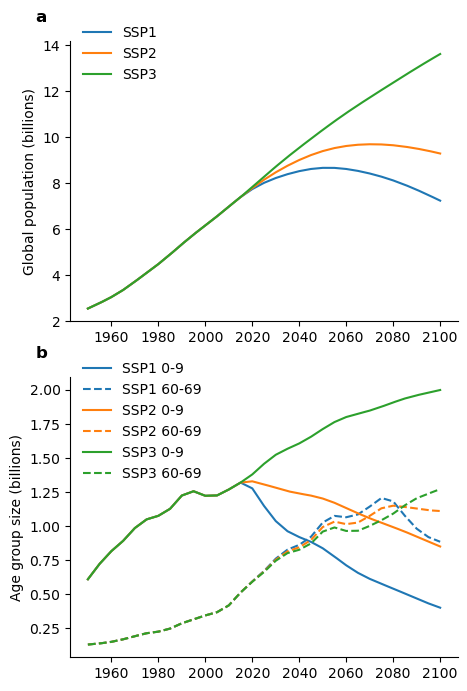

In [39]:
# settings
xpos=-.09
ypos=1.04


fig, axes = plt.subplots(2,1, figsize=(5,8))

ax=axes[0]
ax.set_title('a',loc='left',fontweight='bold',x=xpos,y=ypos)

(da_cohort_sizes_ssp1/1e6).sum(dim='ages').plot(ax=ax, label = 'SSP1')
(da_cohort_sizes/1e6).sum(dim='ages').plot(ax=ax, label = 'SSP2')
(da_cohort_sizes_ssp3/1e6).sum(dim='ages').plot(ax=ax, label = 'SSP3')


ax.legend(frameon=False,bbox_to_anchor=(0, 1.1),loc='upper left')
ax.set_title('')
ax.set_ylabel('Global population (billions)')
ax.set_xlabel('')


ax=axes[1]
ax.set_title('b',loc='left',fontweight='bold',x=xpos,y=ypos)

(da_cohort_sizes_ssp1/1e6).sel(ages=slice(0,9)).sum(dim='ages').plot(ax=ax, label = 'SSP1 0-9')
(da_cohort_sizes_ssp1/1e6).sel(ages=slice(60,69)).sum(dim='ages').plot(ax=ax, label = 'SSP1 60-69',c='C0',ls='--')

(da_cohort_sizes/1e6).sel(ages=slice(0,9)).sum(dim='ages').plot(ax=ax, label = 'SSP2 0-9')
(da_cohort_sizes/1e6).sel(ages=slice(60,69)).sum(dim='ages').plot(ax=ax, label = 'SSP2 60-69',c='C1',ls='--')

(da_cohort_sizes_ssp3/1e6).sel(ages=slice(0,9)).sum(dim='ages').plot(ax=ax, label = 'SSP3 0-9')
(da_cohort_sizes_ssp3/1e6).sel(ages=slice(60,69)).sum(dim='ages').plot(ax=ax, label = 'SSP3 60-69',c='C2',ls='--')

ax.legend(frameon=False, bbox_to_anchor=(0, 1.1),loc='upper left')
ax.set_title('')
ax.set_ylabel('Age group size (billions)')
ax.set_xlabel('')

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

#plt.savefig(os.path.join(figdir,'figSI_globalpop_agegroups_ssp123.png'),dpi=300,transparent=True)

## 1. If demographics were constant at present-day levels


In [40]:
x_hot_days = [0, 1, 50, 100, 150]

da_nAHD = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, temp_target=1.5) 

da_n_people_ndays_models_15_fd, da_prop_people_ndays_models_15_fd = calc_number_proportion_people_atleastxdays_10yr(gs_population_global_2023, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = x_hot_days)

da_nAHD_percapita_peopledays_15_fd = calc_percapita_hotdays_peopledays_1yr(gs_population_global_2023, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

da_nAHD = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, temp_target=2) 

da_n_people_ndays_models_2_fd, da_prop_people_ndays_models_2_fd = calc_number_proportion_people_atleastxdays_10yr(gs_population_global_2023, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = x_hot_days)

da_nAHD_percapita_peopledays_2_fd = calc_percapita_hotdays_peopledays_1yr(gs_population_global_2023, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )


## 2. SSP3-45 instead of SSP2-45

In [41]:

da_nAHD = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, temp_target=1.5) 

da_n_people_ndays_models_15_ssp3, da_prop_people_ndays_models_15_ssp3 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global_2033_ssp3, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = x_hot_days)

da_nAHD_percapita_peopledays_15_ssp3 = calc_percapita_hotdays_peopledays_1yr(gs_population_global_2033_ssp3, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )


da_nAHD = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, temp_target=2) 

da_n_people_ndays_models_2_ssp3, da_prop_people_ndays_models_2_ssp3 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global_2062_ssp3,
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = x_hot_days)


da_nAHD_percapita_peopledays_2_ssp3 = calc_percapita_hotdays_peopledays_1yr(gs_population_global_2062_ssp3, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

## 2 deg with RCP6.0 instead of 4.5

In [42]:
da_nAHD = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, temp_target=2) 

da_n_people_ndays_models_2_rcp6, da_prop_people_ndays_models_2_rcp6 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global_2056, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = x_hot_days)

da_nAHD_percapita_peopledays_2_rcp6 = calc_percapita_hotdays_peopledays_1yr(gs_population_global_2056, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )



da_nAHD = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, temp_target=2) 

da_n_people_ndays_models_2_rcp6_ssp3, da_prop_people_ndays_models_2_rcp6_ssp3 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global_2051_ssp3,
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = x_hot_days)

da_nAHD_percapita_peopledays_2_rcp6_ssp3 = calc_percapita_hotdays_peopledays_1yr(gs_population_global_2051_ssp3, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

# Summary table

In [43]:
def add_population_data(df, col_name, gs_population_global, da_n_people_ndays, da_prop_people_ndays, da_percap):

    # total npeople
    ntot=gs_population_global.sel(ages=slice(0,9)).sum()
    ntot_60=gs_population_global.sel(ages=slice(60,69)).sum()

    #0-9
    n_atleastx=da_n_people_ndays.astype(float).median(dim='model').sel(age_ranges=0).to_pandas()[1:] / 1e6
    prop_atleastx=da_prop_people_ndays.astype(float).median(dim='model').sel(age_ranges=0).to_pandas()[1:]
    percap = da_percap.astype(float).median(dim='model').sel(age_ranges=0).to_pandas()[1]

    #60-60
    n_atleastx_60=da_n_people_ndays.astype(float).median(dim='model').sel(age_ranges=60).to_pandas()[1:] / 1e6
    prop_atleastx_60=da_prop_people_ndays.astype(float).median(dim='model').sel(age_ranges=60).to_pandas()[1:]
    percap_60 = da_percap.astype(float).median(dim='model').sel(age_ranges=60).to_pandas()[1]

    # ratios
    ratio_percap = (da_percap.sel(age_ranges=0,features='per_capita_days') / da_percap.sel(age_ranges=60,features='per_capita_days')).median(dim='model').values


    labels = ['1+','50+','100+', '150+']
    
    # Add population totals
    df.loc["Pop 0-9", col_name] = np.round(ntot.item() / 1e9, 1)

    # Add population and proportion data
    for i in range(len(n_atleastx)):
        df.loc[f"0-9 {labels[i]}", col_name] = f"{prop_atleastx.iloc[i]:.0%} ({n_atleastx.iloc[i].round(-1):.0f})"
    
    df.loc["Pop 60-69", col_name] = np.round(ntot_60.item() / 1e9, 1)

    for i in range(len(n_atleastx)):
        df.loc[f"60-69 {labels[i]}", col_name] = f"{prop_atleastx_60.iloc[i]:.0%} ({n_atleastx_60.iloc[i].round(-1):.0f})"

    # Add ratios
    for i in range(len(n_atleastx)):
        ratio_n = (da_n_people_ndays.sel(age_ranges=0) / da_n_people_ndays.sel(age_ranges=60)).isel(features=slice(1, None)).astype(float).median(dim='model').values[i]
        df.loc[f"ratio n {labels[i]}", col_name] = f"{ratio_n:.1f}"

    for i in range(len(n_atleastx)):
        ratio_prop = (da_prop_people_ndays.sel(age_ranges=0) / da_prop_people_ndays.sel(age_ranges=60)).isel(features=slice(1, None)).astype(float).median(dim='model').values[i]
        df.loc[f"ratio prop {labels[i]}", col_name] = f"{ratio_prop:.1f}"

    df.loc["percap 0-9",col_name] = int(percap.round(0))
    df.loc["percap 60-69",col_name] = int(percap_60.round(0))
    df.loc['ratio percap',col_name]=ratio_percap.round(1)
    
    return df

In [44]:
df_out = pd.DataFrame()


# baseline scenarios, demographics from SSP2-RCP45 year

df_out = add_population_data(df_out, "PD + SSP2_2023", gs_population_global_2023, da_n_people_ndays_models, da_prop_people_ndays_models, da_nAHD_percapita_peopledays)

df_out = add_population_data(df_out, "1.5 + SSP2_2034", gs_population_global_2034, da_n_people_ndays_models_15, da_prop_people_ndays_models_15, da_nAHD_percapita_peopledays_15)

df_out = add_population_data(df_out, "2 + SSP2_2062", gs_population_global_2062, da_n_people_ndays_models_2, da_prop_people_ndays_models_2, da_nAHD_percapita_peopledays_2)


# 1.5 and 2 deg scenario with SSP3-45 instead of SSP2-45

df_out = add_population_data(df_out, "1.5 + SSP3_2033", gs_population_global_2033_ssp3, da_n_people_ndays_models_15_ssp3, da_prop_people_ndays_models_15_ssp3, da_nAHD_percapita_peopledays_15_ssp3)

df_out = add_population_data(df_out, "2 + SSP3_2062", gs_population_global_2062_ssp3, da_n_people_ndays_models_2_ssp3, da_prop_people_ndays_models_2_ssp3, da_nAHD_percapita_peopledays_2_ssp3)


# 1.5 and 2 deg with fixed demographics 

df_out = add_population_data(df_out, "1.5 + SSP2_2023", gs_population_global_2023, da_n_people_ndays_models_15_fd, da_prop_people_ndays_models_15_fd, da_nAHD_percapita_peopledays_15_fd)

df_out = add_population_data(df_out, "2 + SSP2_2023", gs_population_global_2023, da_n_people_ndays_models_2_fd, da_prop_people_ndays_models_2_fd, da_nAHD_percapita_peopledays_2_fd)


# 2 deg with RCP6 (ssp2 and ssp3) instead of RCP45

df_out = add_population_data(df_out, "2 + SSP2_2056", gs_population_global_2056, da_n_people_ndays_models_2_rcp6, da_prop_people_ndays_models_2_rcp6, da_nAHD_percapita_peopledays_2_rcp6)

df_out = add_population_data(df_out, "2 + SSP3_2051", gs_population_global_2051_ssp3, da_n_people_ndays_models_2_rcp6_ssp3, da_prop_people_ndays_models_2_rcp6_ssp3, da_nAHD_percapita_peopledays_2_rcp6_ssp3)

df_out

,PD + SSP2_2023,1.5 + SSP2_2034,2 + SSP2_2062,1.5 + SSP3_2033,2 + SSP3_2062,1.5 + SSP2_2023,2 + SSP2_2023,2 + SSP2_2056,2 + SSP3_2051
Pop 0-9,1.3,1.3,1.1,1.5,1.8,1.3,1.3,1.2,1.7
0-9 1+,74% (970),75% (940),78% (870),75% (1160),78% (1410),75% (990),79% (1040),78% (910),78% (1350)
0-9 50+,29% (380),34% (430),45% (500),34% (530),46% (820),33% (430),43% (560),45% (520),45% (780)
0-9 100+,11% (140),13% (170),23% (260),13% (210),24% (430),13% (170),22% (280),23% (270),23% (400)
0-9 150+,3% (40),4% (50),10% (120),4% (60),10% (190),4% (60),10% (140),10% (120),10% (180)
Pop 60-69,0.6,0.8,1.0,0.8,1.0,0.6,0.6,1.0,1.0
60-69 1+,70% (450),75% (600),80% (820),74% (580),80% (770),73% (460),77% (490),80% (820),80% (770)
60-69 50+,18% (110),23% (190),39% (390),23% (180),39% (380),22% (140),30% (190),36% (370),35% (340)
60-69 100+,6% (40),9% (70),17% (180),9% (70),17% (170),8% (50),13% (80),16% (160),15% (150)
60-69 150+,3% (20),4% (30),9% (90),4% (30),9% (90),4% (20),7% (40),8% (90),8% (80)


In [45]:
#df_out.to_csv(os.path.join(outdirs,'output_SI_tables/fig3_sensitivity_table.csv'))

In [46]:
# pyoung pd, 1.5, 2

d1 = da_prop_people_ndays_models.sel(age_ranges=0, features='prop_atleast_150').values
d2 =  da_prop_people_ndays_models_15.sel(age_ranges=0, features='prop_atleast_150').values
d3 = da_prop_people_ndays_models_2.sel(age_ranges=0, features='prop_atleast_150').values

data = np.vstack([d1, d2, d3])

d = np.array([np.median(data,axis=1), np.min(data, axis=1), np.max(data,axis=1)]).T
df_pyoung = pd.DataFrame(d, index=["2023", "1.5", "2"], columns=["median", "min", "max"]).astype(float)

df_pyoung.round(2)

,median,min,max
2023,0.03,0.01,0.04
1.5,0.04,0.03,0.07
2,0.10,0.06,0.14


In [47]:
gs_population_global_2023.sel(ages=slice(60,69)).sum().values

array(6.38118504e+08)

In [48]:
gs_population_global_2023.sum().values

array(8.00851946e+09)

In [49]:
nyoung = np.array([gs_population_global_2023.sel(ages=slice(0,9)).sum().values, 
                   gs_population_global_2034.sel(ages=slice(0,9)).sum().values,
                   gs_population_global_2062.sel(ages=slice(0,9)).sum().values])
nyoung.round(-7)

# total number of people aged 0-9 in each period in SSP2

array([1.31e+09, 1.26e+09, 1.11e+09])

In [50]:
df_nyoung = df_pyoung.multiply(nyoung, axis=0).astype(float)
df_nyoung.round(-5) / 1e6 # units: millions 

,median,min,max
2023,40.4,19.1,56.1
1.5,51.0,34.5,82.6
2,115.4,63.6,161.5


In [51]:
# pold pd, 1.5, 2

d1 = da_prop_people_ndays_models.sel(age_ranges=60, features='prop_atleast_150').values
d2 =  da_prop_people_ndays_models_15.sel(age_ranges=60, features='prop_atleast_150').values
d3 = da_prop_people_ndays_models_2.sel(age_ranges=60, features='prop_atleast_150').values

data = np.vstack([d1, d2, d3])

d = np.array([np.median(data,axis=1), np.min(data, axis=1), np.max(data,axis=1)]).T
df_pold = pd.DataFrame(d, index=["2023", "1.5", "2"], columns=["median", "min", "max"]).astype(float)

df_pold.round(2)

,median,min,max
2023,0.03,0.01,0.03
1.5,0.04,0.03,0.05
2,0.09,0.07,0.11


In [52]:
nold = np.array([gs_population_global_2023.sel(ages=slice(60,69)).sum().values, 
                   gs_population_global_2034.sel(ages=slice(60,69)).sum().values,
                   gs_population_global_2062.sel(ages=slice(60,69)).sum().values])
nold.round(-7)

array([6.40e+08, 8.00e+08, 1.02e+09])

In [53]:
df_nold = df_pold.multiply(nold, axis=0).astype(float)
df_nold.round(-5) / 1e6 # units: millions 

,median,min,max
2023,16.7,8.3,20.1
1.5,30.6,21.3,40.5
2,93.8,66.1,116.6


In [54]:
# polder pd, 1.5, 2 50 or more, 80-89 yo

d1 = da_prop_people_ndays_models.sel(age_ranges=80, features='prop_atleast_50').values
d2 =  da_prop_people_ndays_models_15.sel(age_ranges=80, features='prop_atleast_50').values
d3 = da_prop_people_ndays_models_2.sel(age_ranges=80, features='prop_atleast_50').values

data = np.vstack([d1, d2, d3])

d = np.array([np.median(data,axis=1), np.min(data, axis=1), np.max(data,axis=1)]).T
df_polder = pd.DataFrame(d, index=["2023", "1.5", "2"], columns=["median", "min", "max"]).astype(float)

df_polder.round(2)

,median,min,max
2023,0.12,0.09,0.18
1.5,0.16,0.10,0.20
2,0.29,0.22,0.34
